<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels_RF_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random forest model

## Installing necessary functions

In [ ]:
%pip install mahotas
%pip install Augmentor
%pip install split-folders tqdm
%pip uninstall -y numpy #these 4 lines were added because of an error with loading the LabelEncoder
%pip uninstall -y setuptools
%pip install numpy
%pip install setuptools
#don't forget to click restart runtime here!

In [ ]:
import itertools
import numpy as np
import mahotas
import cv2
import os
import matplotlib.pyplot as plt
import Augmentor
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab import files
import shutil
from sklearn.model_selection import GridSearchCV
import splitfolders
from sklearn import metrics
import re
from math import copysign
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Creating functions for later use

###Feature extraction

In [ ]:
# FUNCTION TO CALCULATE LEARNABLE FEATURES IN IMAGES


# features description -1:  Hu Moments
def fd_hu_moments(image):
    #thresholding with geen pixel mask
    blue, green, red = cv2.split(image)
    basic=(blue<65) & (green>80)
    dark= (blue<40) & (green>35) & (red <45)
    lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
    lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
    newimg=basic+dark+lightvery+lightmedium
    thres = np.multiply(newimg, 1, dtype='uint8' )
    #Hu moments
    feature = cv2.HuMoments(cv2.moments(thres)).flatten()
    for i in range(0,7):
      if feature[i] !=0:
        feature[i] = -1* copysign(1.0, feature[i]) * np.log10(abs(feature[i]))
    return feature

# feature-descriptor -2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-description -3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COMPUTE THE COLOR HISTOGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[8,8,8], [0, 180, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histogram
    return hist.flatten()

#feature-description -4: sum green pixels as feature
def fd_greenpixels(image):
  #First green counter
  blue, green, red = cv2.split(image)
  basic=(blue<65) & (green>80)
  dark= (blue<40) & (green>35) & (red <45)
  lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
  lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
  newimg=basic+dark+lightvery+lightmedium
  sumpixels=newimg.sum()
  #Second green counter
  newimg2 = (green>(blue+20))&(green>(red+15))
  sumpixels2 = newimg2.sum()
  return sumpixels, sumpixels2

#feature-description -5: sum green pixels as feature
def fd_vegindices(image): #these come from https://isprs-archives.copernicus.org/articles/XLII-3/1215/2018/isprs-archives-XLII-3-1215-2018.pdf
#   this paper also uses these: https://www.sciencedirect.com/science/article/pii/S1470160X16301406?casa_token=8wIIrswmqc8AAAAA:tr0iQCh7kW4ZjbWMLckAAPwQpYsF2GFS3ERnglxFSrYd8C8-WVuREf83BPYjv391ZAlpsz9mPFY
  blue, green, red = cv2.split(image)
  RGBVI = (np.multiply(green, green, dtype=np.uint32) - np.multiply(red, blue, dtype=np.uint32))/(np.multiply(green, green, dtype=np.uint32)+np.multiply(red, blue,dtype=np.uint32 ))
  GLI = ((np.multiply(green,2,dtype=np.uint16 ) - red - blue)/(np.multiply(green,2,dtype=np.uint16 ) +red+blue))
  VARI = ((green-red)/(np.add(red, green, dtype = np.uint16)-blue))
  NGRDI = ((green-red)/(np.add(red, green, dtype = np.uint16)))
  combo = [np.mean(RGBVI), np.mean(GLI), np.mean(VARI), np.mean(NGRDI)]
  return combo

### Oversampling

In [ ]:
#Function to generate extra data by oversampling
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages
        seed = random.randint(0, 1000)

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print ("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.set_seed(seed)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False)


## Data preprocessing

#### Setting directories

In [ ]:
main_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/TrainBreederClasses'
split_path= '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split'
train_path = split_path + "/train"
val_path = split_path + "/val"
output_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputRF' #waar het model opgeslagen moet worden

### Reading data

In [ ]:
#reading in the y data
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
Score = Dataset_multigras['Score MG']

### Creating paths and oversampling

In [ ]:
#setting up model directory
#split folder verwijderen
!rm -rf '{split_path}'
#regression folder verwijderen
!rm -rf '{oversample_path}'
#output folder verwijderen en opnieuw aanmaken
!rm -rf '{output_path}'
os.makedirs(output_path)
#Nieuwe split doen op de folders
splitfolders.ratio(main_path, output=split_path, seed=382, ratio=(0.8, 0.2), group_prefix=None, move=False)

Copying files: 3772 files [03:28, 18.05 files/s]


### Oversample

In [ ]:
#oversample
target_dir = train_path
dir=target_dir
folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
oversample_func(split_path,  folders, target_folders, 938)

saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 1
Initialised with 257 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 1.

Processing BLOK2R32P20.png: 100%|██████████| 681/681 [00:16<00:00, 40.64 Samples/s]


saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 2
Initialised with 884 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 2.

Processing BLOK1R11P31.png: 100%|██████████| 54/54 [00:01<00:00, 36.94 Samples/s]


### Feature extraction and combination with dependent variable

In [ ]:
#creating datasets
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
features_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each species training folder
  dir = os.path.join(train_path, training_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:Breeder_score= np.float32(Score[index])
    except ValueError:Breeder_score=-1
    if Breeder_score>= 4: y = 'Class 1'
    elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
    elif Breeder_score == 3 :y = 'Class 2'

    file = dir + "/" + os.fsdecode(file)
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)

    image = cv2.resize(image, tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices ])

    # update the list of labels and feature vectors
    if Breeder_score>-1:
      y_values_train.append(y)
      features_train.append(global_feature)

print("Completed Training Set Feature Extraction...")

# get the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()

# empty list to hold feature vectors and labels
features_val = []
y_values_val = []
# loop over the validation data sub folder

for val_name in val_labels:
  # join the validation data path and each speciesvalidation folder
  dir = os.path.join(val_path, val_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
      RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
      BlokRowCol=re.findall(r'\d+', RowCol_string[0])
      Blok=int(BlokRowCol[0])
      Row=int(BlokRowCol[1])
      Col=int(BlokRowCol[2])
      index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
      try:Breeder_score= np.float32(Score[index])
      except ValueError:Breeder_score=-1
      if Breeder_score>= 4: y = 'Class 1'
      elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
      elif Breeder_score==3 :y = 'Class 2'
      file = dir + "/" + os.fsdecode(file)

      # read the image and compute features
      image = cv2.imread(file)


      image = cv2.resize(image, tuple((51, 51)))
      fv_hu_moments = fd_hu_moments(image)
      fv_haralick   = fd_haralick(image)
      fv_histogram  = fd_histogram(image)
      fv_greenpixels= fd_greenpixels(image)
      fv_vegindices = fd_vegindices(image)


      # Concatenate global features
      global_val_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

      # update the list of labels and feature vectors
      if Breeder_score>-1:
        y_values_val.append(y)
        features_val.append(global_val_feature)


print("Completed Validation Set Feature Extraction...")

#creating datasets
#creating X datasets
X_train=np.array(features_train)
X_val=np.array(features_val)

#creating y datasets
y_train = np.array(y_values_train)
y_val = np.array(y_values_val)

Completed Training Set Feature Extraction...
Completed Validation Set Feature Extraction...


## Creating and tuning the model

In [ ]:
# #creating the model and hyperparameter tuning
# forest  = RandomForestClassifier(n_estimators=250, max_features='sqrt', class_weight='balanced') #max features is the amount of features for each split
# parameter_grid_forest = {
#   "criterion": ['gini', 'entropy', 'log_loss'], #'gini', 'entropy', 'log_loss'
#   "max_depth": [3,5,7],
#   "ccp_alpha": np.logspace(-3, 0, 10) #I've chosen ccp alpha here, because the book seemed to find cost complexity pruning
#                                       #the best option for pruning a tree.
#   }
# grid_forest = GridSearchCV(forest, parameter_grid_forest, scoring='balanced_accuracy')
# grid_forest.fit(X_train,y_train)
# print('The best parameters are: {}'.format(grid_forest.best_params_))

The best parameters are: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7}


Train balanced Accuracy 0.8576 
Validation balanced Accuracy 0.6573 
Validation F1 score 0.6363 


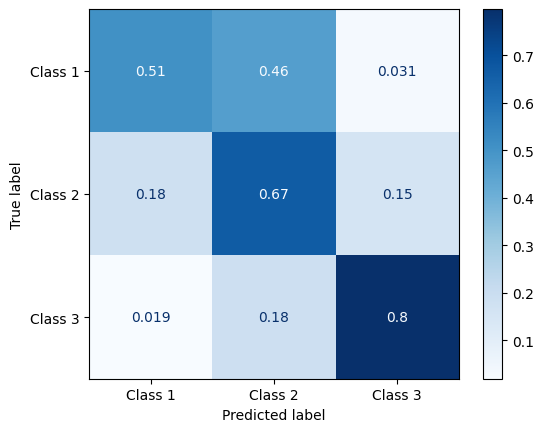

In [ ]:
#testing the optimized model
forest_opt= RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 7, criterion ='entropy',class_weight ='balanced') #class_weight={0: 1, 1: 2},, ccp_alpha = 0.002, max_depth = 7, criterion = 'entropy',ccp_alpha = 0.002, max_depth = 7, criterion = 'entropy', max_features='sqrt',
#class_weight ='balanced',
forest_opt.fit(X_train, y_train)

Y_pred_train = forest_opt.predict(X_train)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred_val=forest_opt.predict(X_val)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred_val)
F1_score = metrics.f1_score(y_val, Y_pred_val, average = 'macro')
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F1 score {:.4f} ".format(F1_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_val, normalize='true', cmap='Blues') #'Blues'

## Feature selection

81
Index([  2,   3,   4,   5,  10,  11,  66,  67,  68,  69,  73,  74,  75,  76,
        77,  81,  82,  83,  84,  90,  91,  92,  98,  99, 130, 131, 132, 138,
       139, 140, 141, 145, 146, 147, 148, 149, 153, 154, 155, 156, 161, 162,
       163, 164, 169, 170, 171, 177, 178, 179, 185, 186, 450, 451, 452, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
       527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537],
      dtype='int64')
Train balanced Accuracy 0.8841 
Validation balanced Accuracy 0.6553 
Validation F1 score 0.6447 


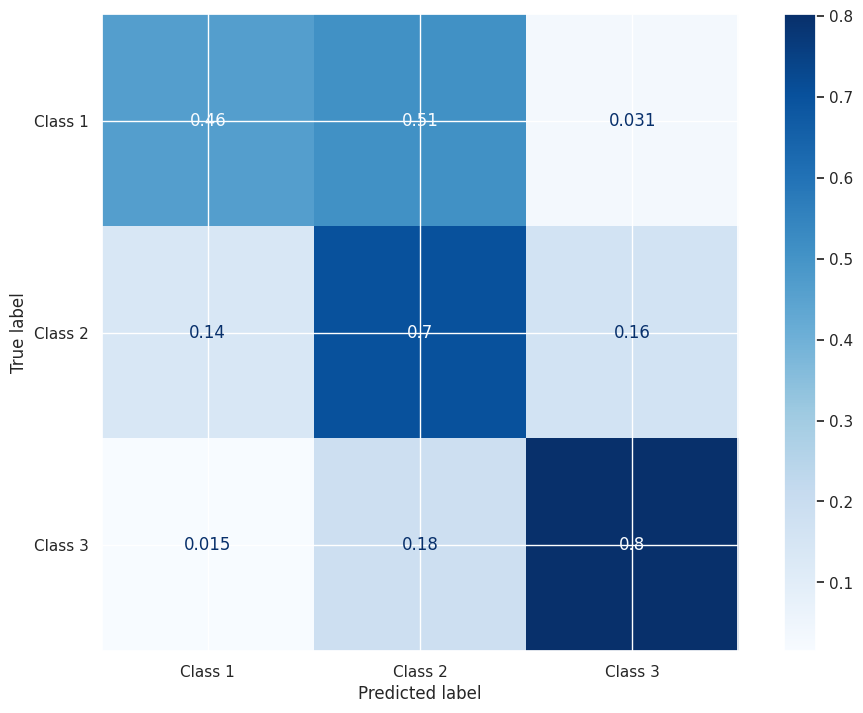

In [ ]:
#feature selection
#selection with mean
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 7, criterion ='entropy',class_weight ='balanced'), threshold='mean')
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
Y_pred_train = forest_opt.predict(X_train_selected)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred_val=forest_opt.predict(X_val_selected)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred_val)
F1_score = metrics.f1_score(y_val, Y_pred_val, average = 'macro')
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F1 score {:.4f} ".format(F1_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_val, normalize='true', cmap='Blues')

26
Index([  2,   3,   4,  66,  67,  68,  74,  75,  83, 139, 170, 178, 185, 514,
       523, 524, 525, 526, 527, 528, 532, 533, 534, 535, 536, 537],
      dtype='int64')
Train balanced Accuracy 0.8696 
Validation balanced Accuracy 0.6358 
Validation F1 score 0.6284 


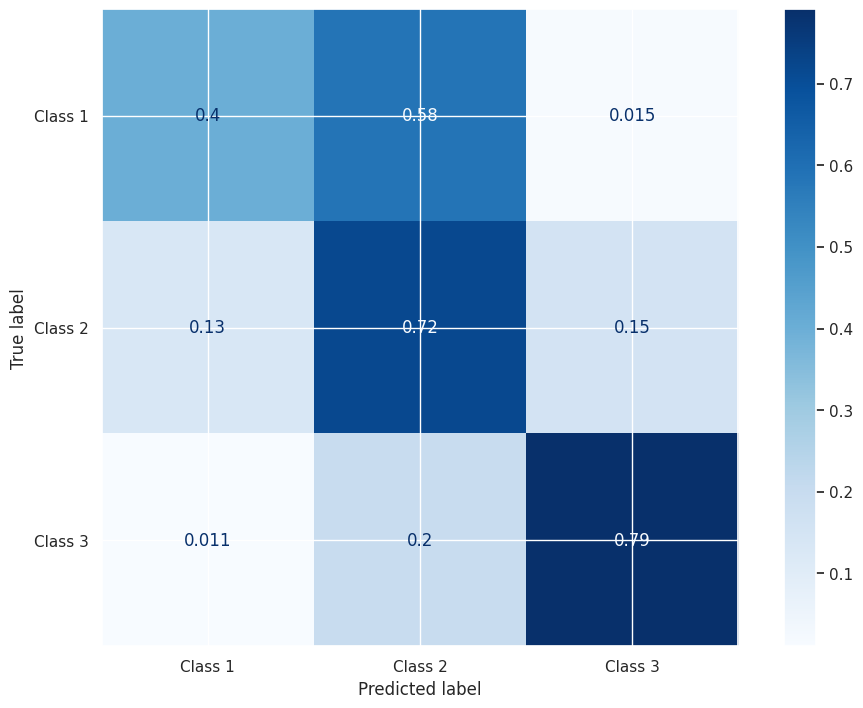

In [ ]:
#feature selection
#selection with 0.01
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 7, criterion ='entropy',class_weight ='balanced'), threshold=0.01)
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
Y_pred_train = forest_opt.predict(X_train_selected)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred_val=forest_opt.predict(X_val_selected)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred_val)
F1_score = metrics.f1_score(y_val, Y_pred_val, average = 'macro')
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F1 score {:.4f} ".format(F1_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_val, normalize='true', cmap='Blues')

['Green Pixels too lenient', 'Green Pixels too strict', 'Colour Histogram 68', 'Colour Histogram 4', 'RGBVI', 'GLI', 'Hu Moments 1', 'Colour Histogram 3', 'Colour Histogram 76', 'Colour Histogram 5', 'VARI', 'Hu Moments 4', 'Colour Histogram 67', 'Colour Histogram 75', 'Hu Moments 2']
Green Pixels too lenient    0.104896
Green Pixels too strict     0.086047
Colour Histogram 68         0.042870
Colour Histogram 4          0.042652
RGBVI                       0.036089
GLI                         0.034674
Hu Moments 1                0.034132
Colour Histogram 3          0.031422
Colour Histogram 76         0.027934
Colour Histogram 5          0.027497
VARI                        0.026515
Hu Moments 4                0.024364
Colour Histogram 67         0.018025
Colour Histogram 75         0.017858
Hu Moments 2                0.017563
dtype: float64


Text(0.5, 1.0, 'RF_classification_0')

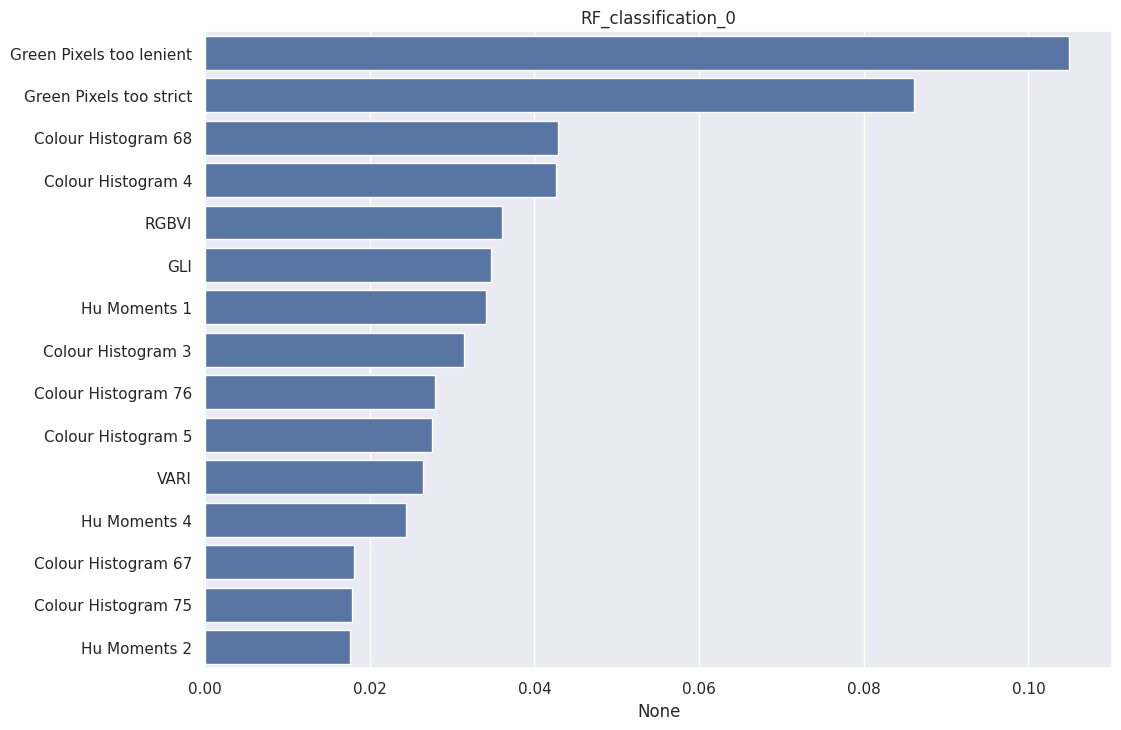

In [ ]:
# Representing feature importance
#names
histo_names = [f"Colour Histogram {i}" for i in range(1,513)]
haralick_names = [f"Haralick Texture {i}" for i in range(1,14)]
Hu_names = [f"Hu Moments {i}" for i in range(1,8)]
Greenpix_names = ['Green Pixels too strict', 'Green Pixels too lenient']
Veg_names = ['RGBVI', 'GLI', 'VARI', 'NGRDI']
feature_names = histo_names + haralick_names + Hu_names + Greenpix_names + Veg_names
feature_names_pd = pd.DataFrame(data=feature_names)
#importances
forest_opt= RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 7, criterion ='entropy',class_weight ='balanced')
forest_opt.fit(X_train, y_train)
importances = forest_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_opt.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
sorted_indices = forest_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = forest_importances[sorted_indices]
Important_feat_names = sorted_feature_names[0:15]
Important_feat_importance = sorted_importances[0:15]

print(Important_feat_names)
print(Important_feat_importance)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=Important_feat_importance, y=Important_feat_names)
plt.title('RF_classification_0')

In [ ]:
#check which histogram feature corresponds to which HSV values
# Read the image
image1=cv2.imread('/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/ClassesBreeder/Class1/BLOK1R10P23.png')
image = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)

# Calculate the 3D color histogram
bins = 8
hist  = cv2.calcHist([image],[0,1,2],None,[8,8,8], [0, 180, 0, 256, 0, 256])
hist_flat = hist.flatten()

# Print the shape of the flattened histogram
print(f'Flattened histogram shape: {hist_flat.shape}')

# Define the bin size for each channel
h_bin_size = 180 // bins
s_v_bin_size = 256 // bins

# Function to get the range of values for a bin index
def get_bin_range(bin_index, bin_size):
    start = bin_index * bin_size
    end = start + bin_size - 1
    return (start, end)

# Iterate through the flattened histogram and print the HSV ranges
for idx in range(hist_flat.size):
    # Calculate the original 3D indices from the flattened index
    h_idx = idx // (bins * bins)
    s_idx = (idx % (bins * bins)) // bins
    v_idx = idx % bins

    h_range = get_bin_range(h_idx, h_bin_size)
    s_range = get_bin_range(s_idx, s_v_bin_size)
    v_range = get_bin_range(v_idx, s_v_bin_size)

    bin_count = hist_flat[idx]
    print(f'Flattened index {idx+1} corresponds to Bin ({h_idx},{s_idx},{v_idx}) representing H in {h_range}, S in {s_range}, V in {v_range} with count {bin_count}')

Flattened histogram shape: (512,)
Flattened index 1 corresponds to Bin (0,0,0) representing H in (0, 21), S in (0, 31), V in (0, 31) with count 0.0
Flattened index 2 corresponds to Bin (0,0,1) representing H in (0, 21), S in (0, 31), V in (32, 63) with count 0.0
Flattened index 3 corresponds to Bin (0,0,2) representing H in (0, 21), S in (0, 31), V in (64, 95) with count 0.0
Flattened index 4 corresponds to Bin (0,0,3) representing H in (0, 21), S in (0, 31), V in (96, 127) with count 11.0
Flattened index 5 corresponds to Bin (0,0,4) representing H in (0, 21), S in (0, 31), V in (128, 159) with count 6.0
Flattened index 6 corresponds to Bin (0,0,5) representing H in (0, 21), S in (0, 31), V in (160, 191) with count 0.0
Flattened index 7 corresponds to Bin (0,0,6) representing H in (0, 21), S in (0, 31), V in (192, 223) with count 0.0
Flattened index 8 corresponds to Bin (0,0,7) representing H in (0, 21), S in (0, 31), V in (224, 255) with count 0.0
Flattened index 9 corresponds to Bin 

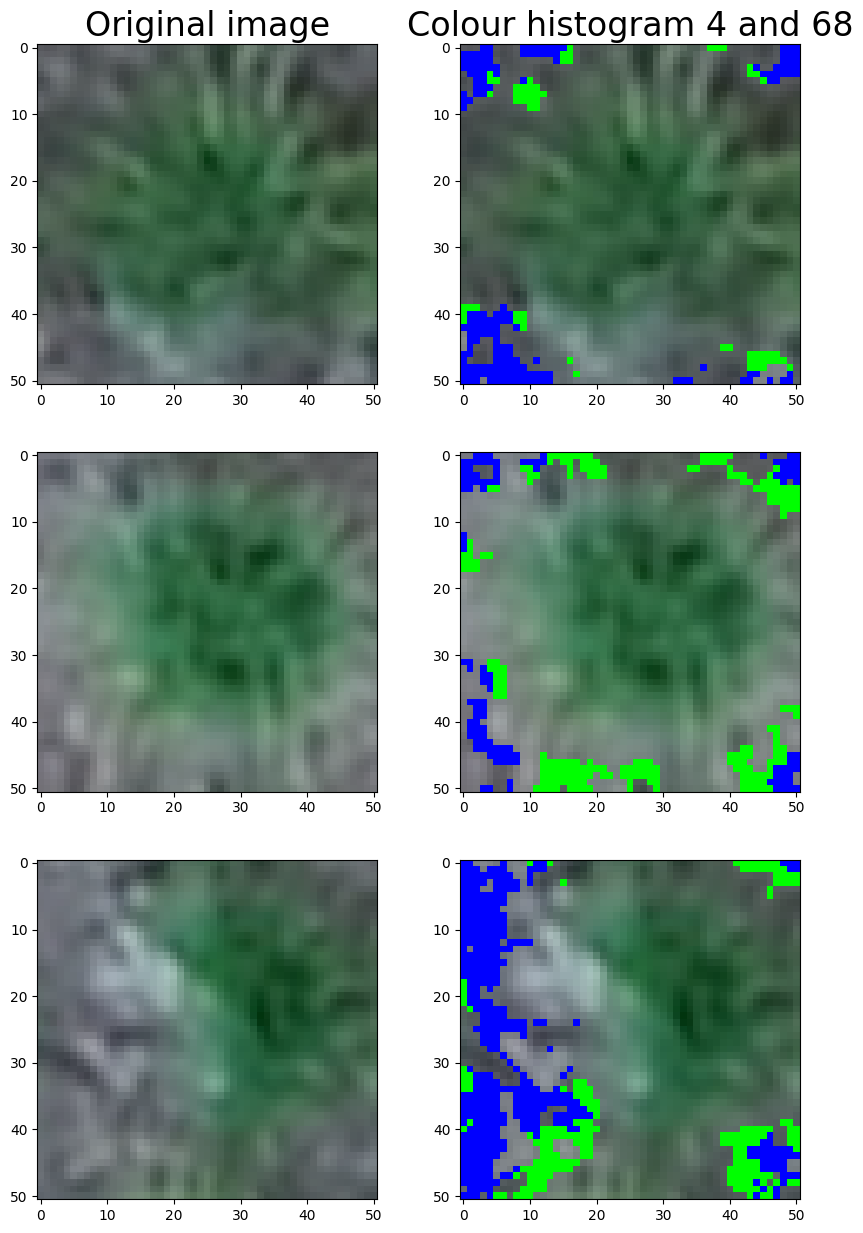

In [ ]:
#creating image HSV zones in features 4 and 68
#Colour histo 68: H in (22, 43), S in (0, 31), V in (96, 127)
#colour hist 4: H in (0, 21), S in (0, 31), V in (96, 127)
image1_o=cv2.imread('/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/ClassesBreeder/Class3/BLOK3R4P16.png')
image2_o=cv2.imread('/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/ClassesBreeder/Class3/BLOK1R30P14.png')
image3_o=cv2.imread('/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/ClassesBreeder/Class3/BLOK2R12P4.png')

image1 = cv2.cvtColor(image1_o, cv2.COLOR_BGR2HSV)
image2 = cv2.cvtColor(image2_o, cv2.COLOR_BGR2HSV)
image3 = cv2.cvtColor(image3_o, cv2.COLOR_BGR2HSV)


Mask68_1 = (image1[:,:,0]>21) & (image1[:,:,0]<44) & (image1[:,:,1]<32) & (image1[:,:,2]>95) & (image1[:,:,2]<128)
Mask4_1 = (image1[:,:,0]<22) &  (image1[:,:,1]<32) & (image1[:,:,2]>95) & (image1[:,:,2]<128)
Mask68_2 = (image2[:,:,0]>21) & (image2[:,:,0]<44) & (image2[:,:,1]<32) & (image2[:,:,2]>95) & (image2[:,:,2]<128)
Mask4_2 = (image2[:,:,0]<22) &  (image2[:,:,1]<32) & (image2[:,:,2]>95) & (image2[:,:,2]<128)
Mask68_3 = (image3[:,:,0]>21) & (image3[:,:,0]<44) & (image3[:,:,1]<32) & (image3[:,:,2]>95) & (image3[:,:,2]<128)
Mask4_3 = (image3[:,:,0]<22) &  (image3[:,:,1]<32) & (image3[:,:,2]>95) & (image3[:,:,2]<128)


# Function to highlight the mask on the original image
def highlight_mask(image, mask, color):
    highlighted = image.copy()
    highlighted[mask] = color
    return highlighted

# Define highlight colors
highlight_color_68 = [0, 255, 0]  # Green
highlight_color_4 = [0, 0, 255]  # blue

# Apply highlights to each image
highlighted_image1 = highlight_mask(image1_o, Mask68_1, highlight_color_68)
highlighted_image1 = highlight_mask(highlighted_image1, Mask4_1, highlight_color_4)

highlighted_image2 = highlight_mask(image2_o, Mask68_2, highlight_color_68)
highlighted_image2 = highlight_mask(highlighted_image2, Mask4_2, highlight_color_4)

highlighted_image3 = highlight_mask(image3_o, Mask68_3, highlight_color_68)
highlighted_image3 = highlight_mask(highlighted_image3, Mask4_3, highlight_color_4)

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(3, 2, 1)
plt.imshow(image1_o)
ax1.set_title('Original image', fontsize=24)
ax2 = fig.add_subplot(3, 2, 2)
plt.imshow(highlighted_image1)
ax2.set_title('Colour histogram 4 and 68', fontsize=24)
ax4 = fig.add_subplot(3, 2, 3)
plt.imshow(image2_o)
ax5 = fig.add_subplot(3, 2, 4)
plt.imshow(highlighted_image2)
ax6 = fig.add_subplot(3, 2, 5)
plt.imshow(image3_o)
ax8 = fig.add_subplot(3, 2, 6)
plt.imshow(highlighted_image3)


## Testing optimal version of model

In [ ]:
#importing test set
test_path = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test'

In [ ]:
#Extracting features and combining with DMY values test set
#creating datasets
# read the training data labels
test_labels = os.listdir(test_path)
# sort the training labesl
test_labels.sort()
# empty list to hold feature vectors and labels
features_test = []
y_values_test = []

# loop over the training data sub folder
for test_name in test_labels:
  # join the training data path and each species training folder
  dir = os.path.join(test_path, test_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:Breeder_score= np.float32(Score[index])
    except ValueError:Breeder_score=-1
    if Breeder_score>= 4: y = 'Class 1'
    elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
    elif Breeder_score == 3 :y = 'Class 2'

    file = dir + "/" + os.fsdecode(file)
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)

    image = cv2.resize(image,tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

    # update the list of labels and feature vectors
    if Breeder_score>-1:
      y_values_test.append(y)
      features_test.append(global_feature)

print("Completed Test Set Feature Extraction...")

#creating datasets
X_test=np.array(features_test)
y_test = y_values_test

#Combining train and validation set to use both as a train set for the final model
X_train_full = np.vstack((X_train,X_val))
y_train_full = np.hstack((y_train,y_val))

Completed Test Set Feature Extraction...


Train balanced Accuracy 0.8415 
Test balanced Accuracy 0.7072 
Test F1 score 0.6819 


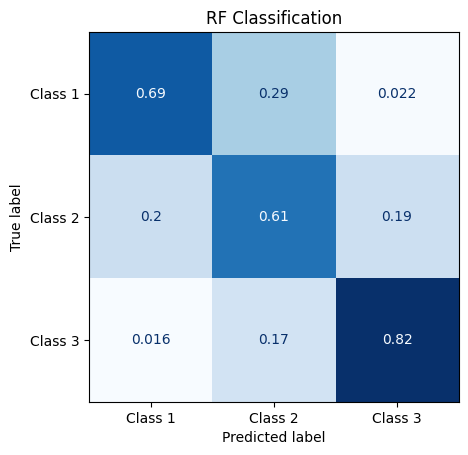

In [ ]:
#Training and testing model
forest_opt= RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy',max_depth=7,ccp_alpha=0.001 ,class_weight='balanced')
forest_opt.fit(X_train_full, y_train_full)

Y_pred_train = forest_opt.predict(X_train_full)
train_accuracy = metrics.balanced_accuracy_score(y_train_full, Y_pred_train)
Y_pred=forest_opt.predict(X_test)
test_accuracy = metrics.balanced_accuracy_score(y_test, Y_pred)
F1_score = metrics.f1_score(y_test, Y_pred, average = 'macro')
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Test balanced Accuracy {:.4f} ".format(test_accuracy))
print("Test F1 score {:.4f} ".format(F1_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, normalize='true', cmap='Blues', colorbar=False)
plt.title('RF Classification')
plt.show()